# Synthetic Aperture Radar (SAR) formulation

NOTE: I JUST REALIZED I FORGOT TO ADD $j$ TO ALL THE COMPLEX EXPONENTIALS  

In SAR we transmit a waveform $h(t)$ at a position $\bm{p}_{tx}$ with our antenna pointed at a position on the ground $\bm{p}_{aim}$.  We trasnmit the waveform at a time $t_{tx}$ at the aimpoint and receive the reflected wave at a time $\tau_{rx}$ later.  Mathematically for a single pulse this can be represented as:
$$x(t) =  \sqrt{\frac{P_{t} G^2 \sigma \lambda^2}{(4\pi)^3 R_{tx}^2R_{rx}^2}}h(t-\tau_{rx})$$
where $h(t)$ is the transmitted waveform.  Recall that to achieve fine range resolution we used a chirp waveform which means we can rewrite this as:
$$h(t) = e^{2\pi f_c t + \pi \gamma t^2}$$
$$x(t) = \sqrt{\frac{P_{t} G_{t} G_{r} \sigma \lambda^2}{(4\pi)^3 R_{tx}^2R_{rx}^2}}e^{2\pi f_c (t-\tau_{rx}) + \pi \gamma (t-\tau_{rx})^2}$$  
Let's simplify this expression a bit.  Let's set the gain scaling terms to a constant $A$:
$$x(t) = Ae^{2\pi f_c (t-\tau_{rx}) + \pi \gamma (t-\tau_{rx})^2}$$
$$A=\sqrt{\frac{P_{t} G_{t} G_{r} \sigma \lambda^2}{(4\pi)^3 R_{tx}^2R_{rx}^2}}$$
Recall that our time delay to a point is computed as follows:
$$\tau_{rx} = \frac{|\bm{p}_{tx} - \bm{p}_{aim}|}{c} + \frac{|\bm{p}_{rx} - \bm{p}_{aim}|}{c}$$  

Using the monostatic approximation (transmitter and receiver) are the same we assume that $\bm{p}_{tx} = \bm{p}_{rx}$ and we can rewrite this as follows:
$$\tau_{rx} = 2\frac{|\bm{p}_{tx} - \bm{p}_{aim}|}{c}$$
The last simplifaction is to define $R = |\bm{p}_{tx} - \bm{p}_{aim}|$ and write the time delay as:
$$\tau_{rx} = \frac{2R}{c}$$  

We can now write the received waveform for a single pulse as:
$$x(t) = Ae^{2\pi f_c (t-\frac{2R}{c}) + \pi \gamma (t-\frac{2R}{c})^2}$$  
Rewriting this we can observe the following
To demodualte the signal (downconvert) we remove the carrier term from the data to bring it to a lower (intermediate frequency).  

$$x_{IF}(t) = \underbrace{Ae^{2\pi f_c (t-\frac{2R}{c}) + \pi \gamma (t-\frac{2R}{c})^2}}_{\text{received signal}}\underbrace{e^{2\pi f_{lo}t}}_{\text{local oscillator}}$$
multiplying this out yields

$$x_{IF}(t) = Ae^{2\pi (f_c - f_{lo})t}  e^{-2f_c\pi \frac{2R}{c}}e^{\pi \gamma (t-\frac{2R}{c})^2}$$


For simplicity, here we will completely remove the carrier ($f_{lo} = f_c$) to arrive at the zero IF solution which means we can re-write this as:

$$x_{IF}(t) = Ae^{\frac{-4\pi f_cR}{c}}e^{\pi \gamma (t-\frac{2R}{c})^2}$$

recall that $\lambda = \frac{c}{f}$ which means we can re-write this as

$$x_{IF}(t) = Ae^{\frac{-4\pi R}{\lambda}}e^{\pi \gamma (t-\frac{2R}{c})^2}$$  

Note that here we have only looked at the perspective of a single pulse.  Let's examine what happens as we send multiple pulses

## Looking at pulses over time (slow time)
In the previous section we looked at a single pulse.  In reality for SAR we send out a train of pulses as we move relative to the aimpoint.  What this means is before we treated the distance to our point $R$ as constant but really it's a function of time $t$.  Let's rewrite our definition of monostatic range as follows:
$$R(t) = |\bm{p}_{tx}(t) - \bm{p}_{aim}(t)|$$ 
This means we can re-write the IF sampled signals as follows:
$$x_{IF}(t) = Ae^{\frac{-4\pi R(t)}{\lambda}}e^{\pi \gamma (t-\frac{2R(t)}{c})^2}$$  
This equation is confusing because we have two "notions" of time:
* Time within the perspective of a single pulse
* Time within the perspective of the flight duration

The scale of time withina single pulse is usually on the order of microseconds ($10^{-6}$) while the time between successive pulses is usually on the order of miliseconds ($10^{-3}$).  We'll define "fast time" as the time within a single pulse which we sample and "slow time" as the time between pulses.  I'll use the following notation for the follwing:
* Fast time: $t$
* Slow time: $\tau$
With that in mind we can rewrite the IF signal as:
$$x_{IF}(t, \tau) = Ae^{\frac{-4\pi R(\tau)}{\lambda}}e^{\pi \gamma (t-\frac{2R(\tau)}{c})^2}$$
where $\tau$ represents the time at which we transmit the $k^{th}$ pulse and $t$ is the time within the ADC window which we sample the $k^{th}$ pulse.  

Before we go into building intuition for what this equation means, let's examine what $R(\tau)$ looks like for a real collection:

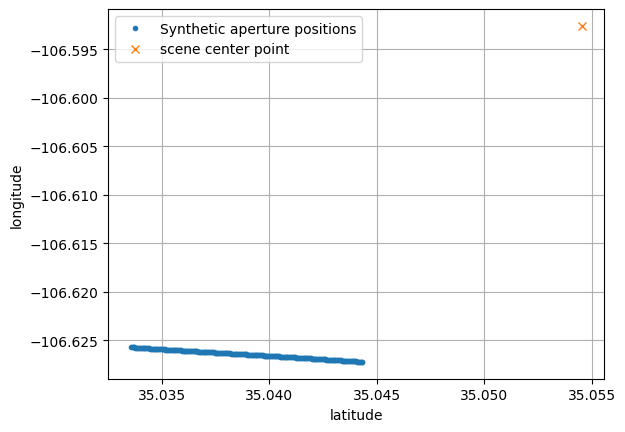

In [19]:
import numpy as np
from sarpy.geometry.geocoords import ecf_to_geodetic
import numpy.polynomial.polynomial as npp
import matplotlib.pyplot as plt

# These values were taken from metadata in https://six-library-github-public.s3.us-east-2.amazonaws.com/sicd_example_1_PFA_RE32F_IM32F_HH.nitf
arp_poly=np.array([
    [-1.49673321e+06,  3.38008795e+00,  3.41940381e-01, -4.19252322e-02,  3.34858667e-03, -1.93457182e-04, 4.91930368e-06],
    [-5.01247649e+06,  4.82305159e+01, -1.52389565e-01, 2.80952869e-02, -2.50772202e-03,  1.02977378e-04, -1.57182110e-06],
    [3.64293277e+06,  6.79510462e+01,  3.42472609e-02, -1.22799448e-02,  1.25281012e-03, -5.58969344e-05, 8.63636351e-07]
])
p_scp=np.array([-1493006.783, -5010561.349,  3643742.621])
t_start=0.0
t_end=14.50183138839202
times = np.linspace(t_start, t_end, 256) 
arp_pos = npp.polyval(times, arp_poly.T).T

arp_pos_llh = ecf_to_geodetic(arp_pos)
scp_llh = ecf_to_geodetic(p_scp)

plt.figure()
plt.plot(arp_pos_llh[:, 0], arp_pos_llh[:, 1], '.', label='Synthetic aperture positions')
plt.plot(scp_llh[0], scp_llh[1], 'x', label='scene center point')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend()
plt.grid()


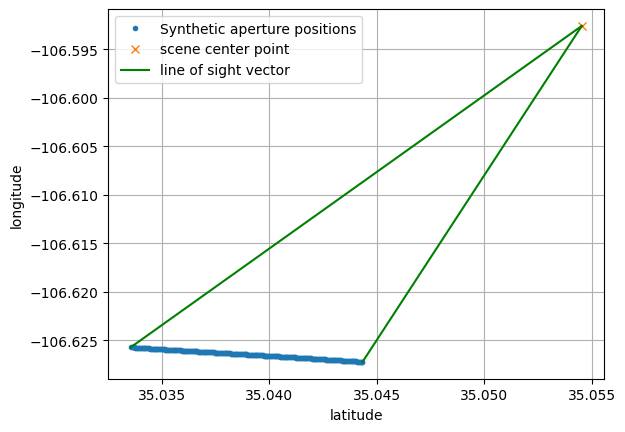

In [18]:
plt.figure()
plt.plot(arp_pos_llh[:, 0], arp_pos_llh[:, 1], '.', label='Synthetic aperture positions')
plt.plot(scp_llh[0], scp_llh[1], 'x', label='scene center point')
plt.plot([arp_pos_llh[0, 0], scp_llh[0]], [arp_pos_llh[0, 1], scp_llh[1]], 'g', label='line of sight vector')
plt.plot([arp_pos_llh[-1, 0], scp_llh[0]], [arp_pos_llh[-1, 1], scp_llh[1]], 'g')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend()
plt.grid()


Now lets look at how the distance to the scene center point changes over the synthetic aperture.  Let's exand our definition of range:
$$R(t) = |\bm{p}_{tx}(t) - \bm{p}_{aim}(t)|$$ 
$$R(t) = \sqrt{(\bm{p}_{tx_x}(t) - \bm{p}_{aim_x}(t))^2 + (\bm{p}_{tx_y}(t) - \bm{p}_{aim_y}(t))^2 + (\bm{p}_{tx_z}(t) - \bm{p}_{aim_z}(t))^2}$$
Let's plot this quantity

Text(0.5, 0, 'time (s)')

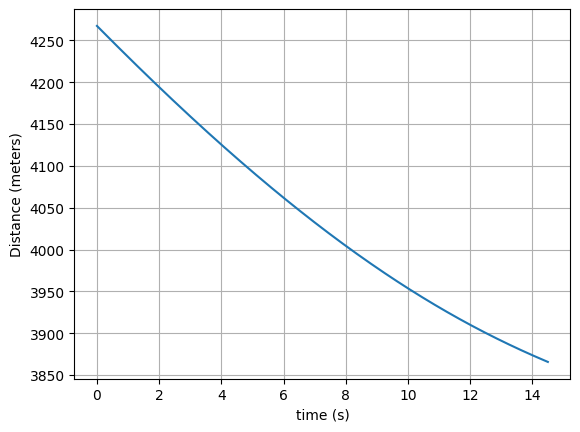

In [21]:
R = np.linalg.norm(arp_pos - p_scp, axis=-1)
plt.figure()
plt.plot(times, R)
plt.grid()
plt.ylabel('Distance (meters)')
plt.xlabel('time (s)')


From here we see that the distance over time looks effectively quadratic.  This is especially interesting if we recall the definition of a chrip signal:
$$x_{chirp}(t) = e^{\gamma t^2}$$
Let's examine the IF signal equation again:
$$x_{IF}(t, \tau) = Ae^{\frac{-4\pi R(\tau)}{\lambda}}e^{\pi \gamma (t-\frac{2R(\tau)}{c})^2}$$
Let's label what each of these terms means:
| term | description |
| ---- | ----------- |
| $e^{\frac{-4\pi R(\tau)}{\lambda}}$| something that varies quadradictly |
| $e^{\pi \gamma (t-\frac{2R(\tau)}{c})^2}$| sreceived waveform which determines distance to target |

This means that our relative motion around the point $p_{aim}$ created a quadratic phase over slow time.  Another way to refer to this is the "azimuth chirp".  To make the fact that $R(\tau)$ is effectively  more apparent.  Let's consider a 2D version of this problem:
INSERT PIC  
our distance over our aperture $L$ can be approximated as:
$$R(x) = \sqrt{R_0^2 + x^2} \approx R_0 + \frac{1}{2R_0}x^2, \quad \frac{-L}{2} \leq x \leq \frac{L}{2}$$  
Where $R_0$ is the broadside range and $L$ is the syntetic aperture length.  

We can re-write our signal as
$$x_{IF}(t, x) = Ae^{\frac{-4\pi (R_0 + \frac{1}{2R_0}x^2)}{\lambda}}e^{\pi \gamma (t-\frac{2(R_0 + \frac{1}{2R_0}x^2)}{c})^2}$$
$$x_{IF}(t, x) = A\underbrace{e^{\frac{-4\pi R_0}{\lambda}} e^{\frac{-2\pi x^2}{\lambda R_0}}}_{\text{Azimuth response}}\underbrace{e^{{\pi \gamma (t-\frac{2R_0}{c} + \frac{x^2}{2R_0 c})}^2}}_{\text{Range response}}$$
Here we see that our quadratic phase term $e^{\frac{-2\pi x^2}{\lambda R_0}}$ is a chirp in azimuth produced by our relative motion around the point


In [22]:
# Code example of different points distance over time

TODO: REFINE THIS

Recall that for a chirrp signal we determined where the chirp was in the receive window by matched filtering.  With SAR:
* Received waveform phase changes due to the change in distance (relative motion) between the sensor and the target
    - Secret sauce of SAR: Use the change in phase of the received waveform as a unique signal for a target at a specicif location then "find" that unique signal in the data
* Correcting for the phase change of a point due to the motion of our sensor relative to that point is essentially modelling what a large antenna would have done to collect the data
* A target's spatial location in azimuth is known by matched filtering with the azimuth response due to the relative motion of the sensor
    - this is referred to as azimuth dechirping or motion compensation
* The process of "synthesizing" the larger antenna by corrlating the data with a point target model is the image formation process
    - It is essentially "decoding the response in azimuth back into a point (matched filtering)  

SAR "works" by tracking the changes in range from the sensor to a point over time.  Some people will refer to the range over time as "range rate".  You will sometimes see people call this "R dot" since mathematically time derivitives are often represented as $\dot{R}$.  Another way to think about range rate is a velocity since it's a mesaure of directional distance over time.  In terms of a radar perspective SAR measures range and Doppler frequency to a point.  

Since SAR is tracking the phase progression of a point over time, they will often refer to raw SAR data as "phase history" since it describes the "history" (time progression) of the phase over time.  

Lastly, to re-iterate, our model of the received signal for a SAR system is:
$$x_{IF}(t, \tau) = Ae^{\frac{-4\pi R(\tau)}{\lambda}}e^{\pi \gamma (t-\frac{2R(\tau)}{c})^2}$$

Where

| term | description |
| ---- | ----------- |
| $e^{\frac{-4\pi R(\tau)}{\lambda}}$| Spatial encoding of points location in azimuth |
| $e^{\pi \gamma (t-\frac{2R(\tau)}{c})^2}$| Received waveform which determines distance to target |
|$A = \sqrt{\frac{P_{t} G_{t} G_{r} \sigma \lambda^2}{(4\pi)^3 R_{tx}^2R_{rx}^2}}$ | microwave reflectivity of point | 

# TODO:
* Create scene with 3 points and show how distance varies over time
* Add rect around equations
* Add more details around 
* Create simulation?